<img src="https://dellaert.github.io/19F-4476/images/proj3/epipole_iphone.png" width="500"/>

<center>Epipolar lines showing camera locations given corresponding points in two views of a scene.<center> 

# PS 2: Projection Matrix and Fundamental Matrix Estimation with RANSAC

In this problem set, we will cover the following main topics:
1. Projection Matrix
2. Fundamental Matrix   
3. Fundamental Matrix with RANSAC 


## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from proj2_code.utils import *

In [2]:
np.set_printoptions(suppress=True) # Suppresses printing in scientific notation

## Notations
* $w$ denotes the world, $c$ denotes the camera
* The superscript on the left denotes the coordinate system of the variable:
    * ${}^w \mathbf{X}$ is the coordinates of point $X$ in the world coordinate system
* The subscript on the right denotes the object or index
    * ${}^w \mathbf{R}_c$ is the rotation for camera $c$ in the world coordinate system
    * ${}^w \mathbf{X}_i$ denotes the coordinates of the $i$th point

# Part 1 Projection Matrix Estimation

**Learning Objective**: (1) Understanding the the camera projection matrix and (2) estimating it using fiducial objects for camera projection matrix estimation and pose estimation.

**Introduction**

In this first part you will perform pose estimation in an image taken by an uncalibrated camera. As we saw in class, pose estimation is incredibly useful; it is used in VR, AR, controller tracking, autonomous driving, and even satellite docking. Recall that for a pinhole camera model, the camera matrix $P∈\mathbb{R}^{3×4}$ is a projective mapping from world (3D) to pixel (2D) coordinates *defined up to a scale*.

\begin{align}
\mathbf{x} & \cong f({}^w \mathbf{X};\mathbf{P}) = \mathbf{P} \ ^{w} \mathbf{X} \\
\implies
\begin{bmatrix}
    u \\
    v \\
    1
\end{bmatrix}
&\cong
\begin{bmatrix}
    s \cdot u \\
    s \cdot v \\
    s
\end{bmatrix}
=
\begin{bmatrix}
p_{11} & p_{12} & p_{13} & p_{14} \\
p_{21} & p_{22} & p_{23} & p_{24} \\
p_{31} & p_{32} & p_{33} & p_{34} \\
\end{bmatrix}
\begin{bmatrix}
    {}^w X \\
    {}^w Y \\
    {}^w Z \\
    1
\end{bmatrix}
\end{align}

Above s is an arbitrary scale factor. The projection matrix can also be decomposed into intrinsic parameters $\mathbf{K}$ and extrinsic parameters ${}^w\mathbf{R}_c ^T\left[\mathbf{I}\mid -{}^w\mathbf{t}_c  \right]$.

\begin{align}
\mathbf{P} &= \mathbf{K}\ {}^w\mathbf{R}_c ^T\left[\mathbf{I}\mid -{}^w\mathbf{t}_c  \right] \\
\mathbf
{P} &=
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

Let’s look more carefully into what each of the individual parts of the decomposed matrix mean. The homogenous vector coordinates $({}^w X, {}^w Y, {}^w Z,1)$ of ${}^w \mathbf{X}$ indicate the position of a point in 3D space in the world coordinate system. The matrix $\left[\mathbf{I}\mid -{}^w\mathbf{t}_c  \right]$ represents a translation and the matrix ${}^w \mathbf{R}^T_c$ represents a rotation. When combined they convert points from the world to the camera coordinate system. An intuitive way to understand this is to think about how aligning the axes of the world coordinate system to the ones of the camera coordinate system can be done with a rotation and a translation.

<img src="https://dellaert.github.io/19F-4476/images/proj3/coordiante_systems.png" width="500"/>
<center>The distinction between camera coordinate and world coordinate systems is a rotation and a translation.</center>

**Note:** This introduction is essential for Part 1 and Part 2 of this notebook. Please make sure you understand this. If you need some clarifications, please visit one of our office hours.

In this part of the project you will learn how to estimate the projection matrix using objective function minimization, how you can decompose the camera matrix, and what knowing these lets you do.


## Part 1.1 Implement Camera Projection

In this initial part, you will implement camera projection in the `projection(P, points_3d)` from world coordinates ${}^w \mathbf{X}_i = [X_i, Y_i, Z_i]$ to non-homogenous pixel coordinates $\mathbf{x}_i = [x_i, y_i]$, for any index $i$.

It will be helpful to recall the equations to convert to pixel coordinates

\begin{align}
x_i = \frac{p_{11}X_i+p_{12}Y_i + p_{13}Z_i + p_{14}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}} \quad y_i = \frac{p_{21}X_i+p_{22}Y_i + p_{23}Z_i + p_{24}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}}
\end{align}

**TODO:** implement `projection()` in `projection_matrix.py`

In [3]:
import projection_matrix

from proj2_unit_tests.part1_unit_test import (
    verify, 
    test_projection, 
    test_objective_func,
    test_decompose_camera_matrix,
    test_calculate_camera_center,
    test_estimate_camera_matrix)

In [4]:
print('Test for camera projection:', verify(test_projection))

Test for camera projection: "Correct"


## Part 1.2 Objective (cost) function to refine the projection matrix

A camera projection matrix maps points from 3D into 2D. How can we use this to estimate its parameters? Assume that we have N known 2D-3D correspondences for a set of points, that is, for points with index $i= 1\dots N$ we have both access to the respective 3D coordinates ${}^w \mathbf{X}_{i}$ and 2D corrdinates $\mathbf{x}_{i}$. Let $\hat{\mathbf{P}}$ be an estimation for the camera projection matrix. We can determine how accurate the estimation is by measuring the reprojection error summed over all indices:

\begin{align}
\sum_{i=1}^N ( \color{purple}{\hat{\mathbf{P}}\ {}^w \mathbf{X}_i-\mathbf{x}_i })^2
\end{align}

between the 3D points projected into 2D $\hat{\mathbf{P}} \ {}^w \mathbf{X}_i$ and the known 2D points $\mathbf{x}_i$, both in **non-homogeneous** coordinates. Therefore we can estimate the projection matrix itself by minimizing the reprojection error with respect to the projection matrix

\begin{align}
\underset{\hat{\mathbf{P}}}{\arg\min}\sum_{i=1}^N (\hat{\mathbf{P}}\ {}^w \mathbf{X}_i -\mathbf{x}_i )^2 .
\end{align}

In this part, you will implement the objective function `objective_function(x, **kwargs)` that will be passed to `scipy.optimize.least_squares` for minimization with the Levenberg-Marquardt algorithm. The input to this function is a [vectorized](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) camera matrix, the output is the term that gets squared in the objective function and should also be vectorized. Scipy takes care of the squaring + summation part.

**TODO:** implement `objective_function()` in `projection_matrix.py`

In [5]:
print('Test for objective_function:', verify(test_objective_func))

Test for objective_function: "Correct"


## Part 1.3:Estimating the projection matrix given initial estimation, 3D-2D point correspondence and previous objective function

Optimizing the reprojection loss using Levenberg-Marquardt requires a good initial estimate for $\mathbf{P}$. This can be done by having good initial estimates for $\mathbf{K}$ and ${}^w\mathbf{R}_c^T$ and ${}^w \mathbf{t}_c$ which you can multiply to then generate your estimated $\mathbf{P}$. In this part, to make sure that you have the least squares optimization working properly we will provide you with an initial estimate. In the function you will have to implement in this part, `estimate_projection_matrix()`, you will have to pass the initial guess to `scipy.optimize.least_squares` and get the appropriate output.

Note: because $P$ has only 11 degrees of freedom, we fix $ \mathbf{P}_{34=1} $.

In [6]:
initial_guess_K = np.array([[ 500,   0, 535],
                            [   0, 500, 390],
                            [   0,   0,  -1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_t = np.array([300, 300, 30]).reshape(3, 1)

initial_guess_I_t = np.hstack((np.eye(3), initial_guess_t))

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [7]:
# set the paths and load the data
pts2d_path = '../data/pts2d-pic_b.txt'
pts3d_path = '../data/pts3d.txt'
img_path   = '../data/pic_b.jpg'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(img_path)

### Estimate the projection matrix given corresponding 2D & 3D points

**TODO:** complete the `estimate_camera_matrix()` in `projection_matrix.py`

`ftol` termination condition is satisfied.
Function evaluations 1019, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 2.76e+05.
Time since optimization start 0.08533620834350586
The projection matrix is
 [[ -2.04554471   1.18126294   0.4055897  244.82283619]
 [ -0.45582852  -0.30414815   2.14988436 166.18819426]
 [ -0.00224223  -0.00109957   0.00057155   1.        ]]
The total residual is 14.711445


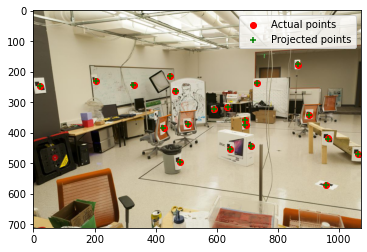

In [8]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/pic_b.jpg')


**TODO:** copy this image (Right click -> Copy Image) to the report (Slide 2, left)

In [9]:
print('Test for estimate_camera_matrix:', verify(test_estimate_camera_matrix))

`ftol` termination condition is satisfied.
Function evaluations 1019, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 2.76e+05.
Time since optimization start 0.07784223556518555
Test for estimate_camera_matrix: "Correct"


## Part 1.4 Decompose projection matrix by RQ decomposition

Recall that $ \mathbf{P} =\mathbf{K}\ {}^w\mathbf{R}^T_c[\mathbf{I}| -{}^w\mathbf{t}_c] $. Rewriting this gives us:

\begin{align} 
\mathbf{P} &= [\mathbf{K}\ {}^w\mathbf{R}^T_c| - \mathbf{K}\ {}^w\mathbf{R}^T_c {}^w\mathbf{t}_c] \\
&= [\mathbf{K}\ {}^c\mathbf{R}_w| \mathbf{K}\ {}^c\mathbf{t}_w] \\
&= [\mathbf{M}| \mathbf{K}\ {}^c\mathbf{t}_w]. 
\end{align}

**Note:** Pay attention to the flip in coordinate system in line 2. Do not proceed further if you have questions about this step. Working out an example by hand helps understand this, particularly the translation portion. The TAs will be happy to help you understand the coordinate system.

Where $\mathbf{M} = \mathbf{K}\ {}^c\mathbf{R}_w $ is the first 3 columns of $\mathbf{P}$. An operation known as RQ decomposition which will decompose $ \mathbf{M} $ into an upper triangular matrix $\mathbf{R}$ and an orthonormal matrix $ \mathbf{Q} $ such that $ \mathbf{RQ} = \mathbf{M} $, where the upper triangular matrix will correspond to $ \mathbf{K} $ and the orthonormal matrix to $ {}^c\mathbf{R}_w $. In this part you will implement `decompose_camera_matrix(P)` that takes as input the camera matrix $\mathbf{P}$ and outputs the intrinsic $\mathbf{K}$ and rotation matrix ${}^c \mathbf{R}_w$, 

**TODO:** implement `decompose_camera_matrix()` in `projection_matrix.py`

In [10]:
print('Test for decomposing projection matrix:', verify(test_decompose_camera_matrix))
K, cRw = projection_matrix.decompose_camera_matrix(P)

Test for decomposing projection matrix: "Correct"


## Part 1.5 Calculate Camera Center by previous optimized P, intrinsic matrix K and rotation matrix ${}^w\mathbf{R}^T_c $

In this part in `projection_matrix.py` you will implement `calculate_camera_center(P, K, cRw)` that takes as input the 
projection $\mathbf{P}$, intrinsic $\mathbf{K}$ and extrinsic ${}^c\mathbf{R}_w$ matrix and outputs the camera position in world coordinates.

**TODO:** complete `calculate_camera_center` in `projection_matrix.py`

In [11]:
print('Test for calculating camera center:', verify(test_calculate_camera_center))
center = projection_matrix.calculate_camera_center(P, K, cRw)

Test for calculating camera center: "Correct"


We can now visualize the camera center and the camera coordinate system as well as the  the world coordinate system.

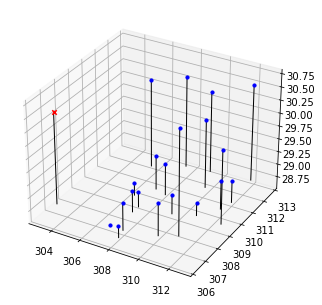

In [12]:
plot3dview(points_3d, center)

### Questions
*put these answers in your report* (Slide 2)

1. What is the minimum number of 3D-2D point correspondences needed to estimate the projection matrix? Why?

## Part 2: Taking Your Own Images and Estimating the Projection Matrix + Camera Pose

In part 1 you were given a set of known points in world coordinates. In this part of the assignment you will learn how to use a fiducial---an object of known size that can be used as a reference. Any object for which you have measured the size given some unit (in this project you should use centimeters).

![projection_figure.png](https://dellaert.github.io/19F-4476/images/proj3/projection_figure.png)

<center>Example of how one cuboid of known dimensions can be used as a fiducial to create multiple world coordinate systems<center>

 <br>

The figure above illustrates how a cuboid of known dimension can be used to create a world coordinate system and a set of points with known 3D location. Choose an object that you will use as a fiducial (we recommend using a thick textbook) and measure it. Using a camera capture two images of the object (you will estimate the camera parameters for both images) keeping in mind the considerations discussed in class for part 2 and fundamental matrix estimation if you want to reuse these images. When taking the images, try to estimate the pose of the camera lens of your phone in the world coordinate system.

Now that you have the dimension of your object (3D points), you can use the Jupyter notebook to find the image coordinates of the 3D points create your own 2D-3D correspondences for each image. For each of your 2 images, make initial estimates for $\mathbf{P}$ and if your estimate is good, using your code from the previous part you should be able to estimate both the the projection matrix and the camera pose. Use the code available in the Jupyter notebook to visualize your findings.

### Part 2.1 Take two images of your fiducial object and measure the corresponding 2D and 3D points

**TODO:** take two images by yourself and save it under the *../data/* path. Please consider using a **box-like fiducial object**, for example a book, because you will need to mark the vertices over your fiducial object, and it's easier to use a box-like fiducial object. Fill out the `points_3d` variable with the 3D point locations of the points you'll use for correspondences, and `points2d_img1` and `points2d_img2` with these coordinate values.

**TODO:** Copy those two images to the report

In [13]:
image1_path = '../data/box_img1.jpg'
image2_path = '../data/box_img2.jpg'

img1 = load_image(image1_path)
img2 = load_image(image2_path)

Measure your fiducial object and define a coordinate system. Fill out the `points_3d` variable with the 3D point locations of the points you'll use for correspondences.

In [14]:
points_3d = np.array([[0  , 0   , 0  ],
                      [13 , 0   , 0  ],
                      [0  , 8.2 , 0  ],
                      [0  , 0   , 6.7],
                      [13 , 0   , 6.7],
                      [13 , 8.2 , 6.7],
                      [0  , 8.2 , 6.7]])

Remember the units you have taken this measurements in. Use the same units when talking about world coordinate system later.

Now for each image, find the 2D pixel locations of your 3D points. Hovering over the interactive images below, and it will give you the `x,y` coordinates of your cursor on the image. The coordinates will be displayed in the bottom right corner. You can use the lower left side controls to zoom into the image for more precise measurements. 

<IPython.core.display.Javascript object>


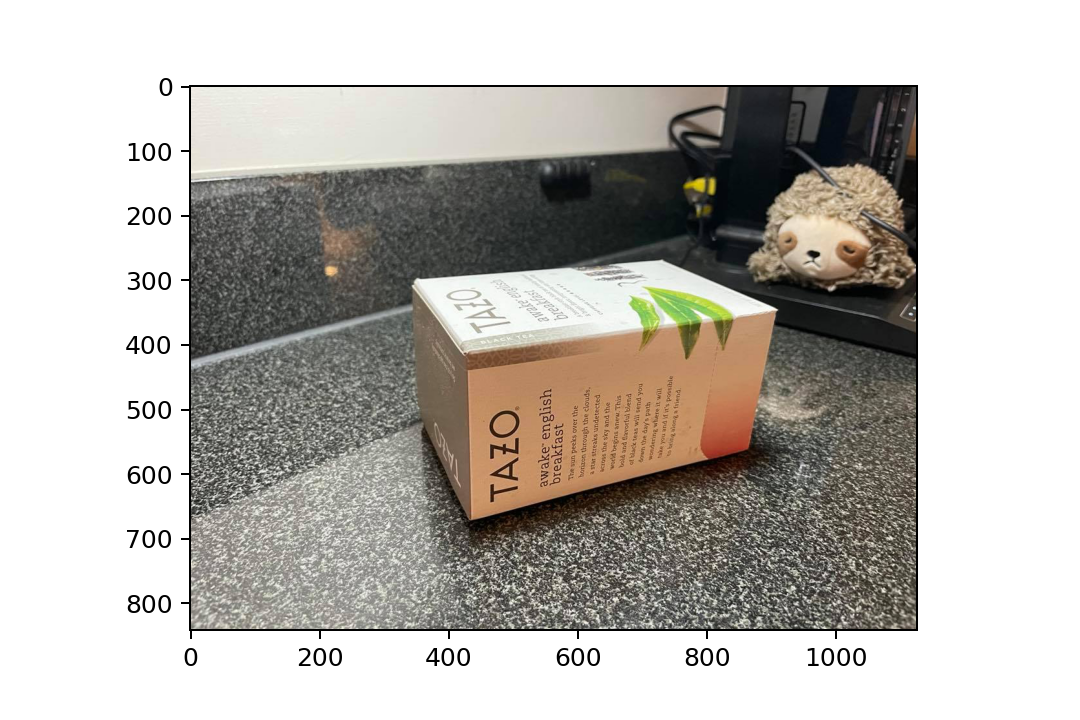

In [15]:
# it's known to have problem (showing blank plot) when switching from `matplotlib inline` 
# to `matplotlib notebook`, and calling `matplotlib notebook` twice can resolve that
# in some cases. 
# refer: https://stackoverflow.com/questions/41125690/matplotlib-notebook-showing-a-blank-histogram?noredirect=1&lq=1
%matplotlib notebook
%matplotlib notebook

# plotting image 1
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img1)

In [16]:
points2d_img1 = np.array([[432,  672],
                          [862,  563],
                          [355,  525],
                          [424,  416],
                          [905,  347],
                          [726,  265],
                          [347,  300]])

<IPython.core.display.Javascript object>


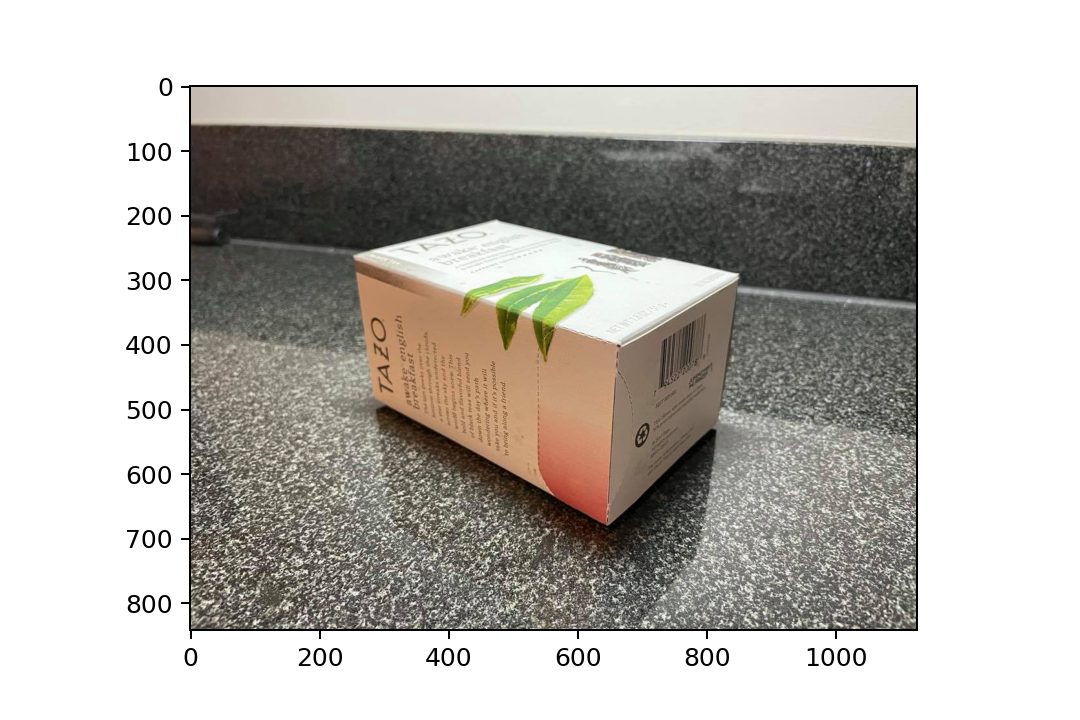

In [17]:
# it's known to have problem (showing blank plot) when switching from `matplotlib inline` 
# to `matplotlib notebook`, and calling `matplotlib notebook` twice can resolve that
# in some cases. 
# refer: https://stackoverflow.com/questions/41125690/matplotlib-notebook-showing-a-blank-histogram?noredirect=1&lq=1
%matplotlib notebook
%matplotlib notebook

# plotting image 2
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img2)

In [18]:
points2d_img2 = np.array([[277, 485],
                          [641, 683],
                          [479, 400],
                          [250, 257],
                          [661, 408],
                          [846, 292],
                          [475, 202]])

Our objective function will need to read the measurements you just saved from disk. We need to save this data now.

In [19]:
np.savetxt('../data/pts3d_fiducial.npy', points_3d)
np.savetxt('../data/pts2d_image1.npy', points2d_img1)
np.savetxt('../data/pts2d_image2.npy', points2d_img2)

## Part 2.2 Making your own $\mathbf{K}$,  ${}^w\mathbf{R}_c^T$ and $[\mathbf{I}|{}^w\mathbf{t}_c]$ estimates and visualize your camera pose.

Make a **good** initial estimate of the projection matrix. For rotations, you can try to guess the angle of rotation along each axis in jumps of 30 degrees (i.e. 0, 30, 60, 90). For the translation, use the same unit you used for 3D points. You need to get the answer in the same ballpark, i.e. do not use 300cm when the actual distance was 30cm. However, 25cm should be fine.

Note the convention of the camera coordinate system and the world coordinate system again. World coordinate system is up to you, but for camera Z shoots out of the camera, Y goes down the camera and X goes to the right.

In [20]:
initial_guess_K = np.array([[ 500,   0, 2024],
                            [   0, 500, 1518],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_t = np.array([-30, -30, 30]).reshape(3, 1)

initial_guess_I_t = np.hstack((np.eye(3), initial_guess_t))

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [21]:
# set the paths and load the data
pts2d_path = '../data/pts2d_image1.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([421. , 562.5])

Visualize your estimate for the camera pose relative to the world coordinate system. RGB colors correspond with XYZ (first, second and third coordinate). Be mindful of whether you should be passing R or R.T in for your rotation matrix.

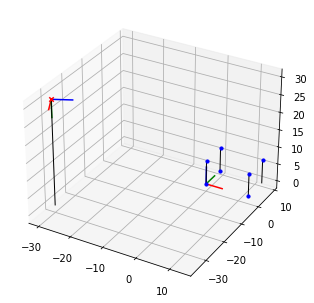

In [22]:
%matplotlib inline
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T)

**TODO:** check the plot above roughly corresponds with how you captured the image. For the camera, x axis should go to the right of the camera, y axis down, and z axis projected out of the camera.

**TODO:** copy this image to the report (Slide 4, left)

View the optimization results given your initial guess. If your initial guess is poor the optimizition **will not** work.

`ftol` termination condition is satisfied.
Function evaluations 296, initial cost 1.4941e+10, final cost 8.9639e+01, first-order optimality 7.74e-02.
Time since optimization start 0.03178262710571289
The projection matrix is
 [[ 46.79734576   3.38413834  -8.78873423 432.8402184 ]
 [  0.76353644  -0.6123765  -46.53930989 675.19354793]
 [  0.01617143   0.03596577  -0.01826357   1.        ]]
The total residual is 33.329648


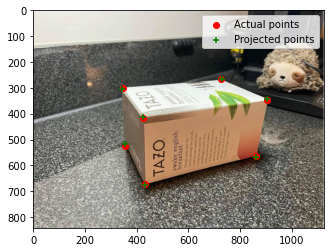

In [23]:
P1 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
print('The projection matrix is\n', P1)

[projected_2d_pts, residual] = evaluate_points(P1, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

**TODO:** copy this image to the report (Slide 5, left)

*Repeat for image 2.*

In [24]:
# set the pats and load the data
pts2d_path = '../data/pts2d_image2.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([421. , 562.5])

In [25]:
initial_guess_K = np.array([[ 500,   0, 2024],
                            [   0, 500, 1518],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  -0.5]])

initial_guess_t = np.array([-30, -10, 30]).reshape(3, 1)

initial_guess_I_t = np.hstack((np.eye(3), initial_guess_t))

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

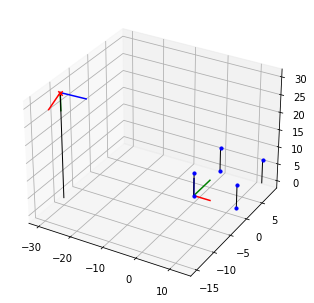

In [26]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T) #change this plot to show the world coordinate system better

**TODO:** copy this image to the report (Slide 4, right)

`ftol` termination condition is satisfied.
Function evaluations 323, initial cost 1.5332e+10, final cost 3.1352e+01, first-order optimality 9.30e-03.
Time since optimization start 0.03402280807495117
The projection matrix is
 [[ 16.12306611  36.80387021  -8.53096414 278.73979176]
 [  2.61441262  -0.94730286 -38.4947713  487.70299821]
 [ -0.01823471   0.02604415  -0.01654732   1.        ]]
The total residual is 18.702712


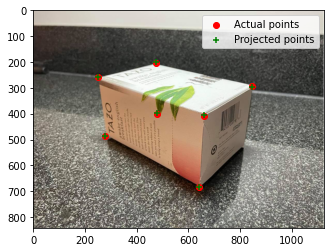

In [27]:
P2 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
#M = sc.calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', P2)

[projected_2d_pts, residual] = evaluate_points(P2, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image2_path)
#visualize_points(points_2d, projected_2d_pts)

**TODO:** copy this image to the report (Slide 5, right)

## Part 2.3 Visualizing both camera poses in the world coordinate system

[ -5.1925595  -18.02504499  14.66001441]
[ 21.93872202 -13.82366882  14.49950349]


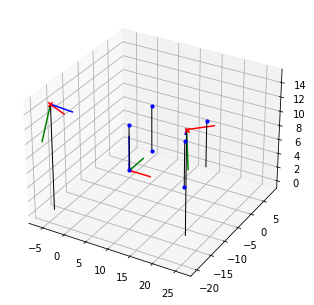

In [28]:
K1, R1 = projection_matrix.decompose_camera_matrix(P1)
center_1 = projection_matrix.calculate_camera_center(P1, K1, R1);
print(center_1)

K2, R2 = projection_matrix.decompose_camera_matrix(P2)
center_2 = projection_matrix.calculate_camera_center(P2, K2, R2);
print(center_2)

plot3dview_2_cameras(points_3d, center_1, center_2, R1.T, R2.T)

**TODO:** Copy this plot to the report (Slide 6)

# Part 3 Fundamental Matrix Estimation

In this part you'll be estimating the fundamental matrix. You'll be using a least squares optimizer from SciPy. (Documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

The least squares optimizer takes an objective function, your variables to optimize, and the points that you want to fit your model to. In this case, the objective function is to minimize the point to line distance, where the line is the projection of a point onto another image by the fundamental matrix, and the point is an actual point of a feature in that image. The variable that you want to optimize would be the 9 values in the 3x3 Fundamental Matrix. The points that you are optimizing over are provided to you, and they are the homogeneous coordinates of corresponding features from two different images of the same scene.

## Part 3.1 Distance computation

We will first write a function to compute distance of 2D point from 2D line.

\begin{align}
    d(line=[a, b, c], point = [u, v, w=1]) = \frac{au + bv + c}{\sqrt{a^2 + b^2}}
\end{align}

**TODO:** implement `point_line_distance` in `fundamental_matrix.py`

In [ ]:
from proj2_unit_tests.test_fundamental_matrix import verify
from proj2_unit_tests.test_fundamental_matrix import TestFundamentalMatrix

test_fundamental_matrix_stereo = TestFundamentalMatrix()
TestFundamentalMatrix.setUp(test_fundamental_matrix_stereo)
print("test_point_line_distance(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance))
print("test_point_line_distance_zero(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance_zero))

We will now use the point-line distance function to compute the symmetric epipolar error between measurements $x_0$ and $x_1$ of the same 3D point under 2 cameras. The two cameras are related by fundamental matrix $F$.

$F x_1$ gives the epipolar line in camera 0, and $x_0$ should ideally lie on this line. Similarly, $F^T x_0$ is the epipolar line in camera 1.

The symmetric epipolar error is computed as:
\begin{align}
    \color{red}{d(Fx_1, x_0)}^2 + \color{red}{d(F^T x_0, x_1)}^2
\end{align}

In actual images, we will have multiple $(x_0 x_1)$s between two images. Hence you will implement a function to compute the symmetric error for a list of points. Keep in mind that SciPy does the squaring and summing for you, so all you have to do in `signed_point_line_errors()` is return a list of each individual error. So if there are 9 points, you have to calculate the `point_line_distance()` between each pair from $Fx_1$ to $x_0$ and also $F^Tx_0$ to $x_1$, then append all errors to a list, such that you end up returning a list of length 18. 

SciPy will take the list and square each element and sum everything for you. The red parts in the equation below are the parts you'll need to implement.


**TODO:** Implement `signed_point_line_errors()` in `fundamental_matrix.py`.

In [ ]:
from proj2_unit_tests.test_fundamental_matrix import TestFundamentalMatrix2, TestFundamentalMatrix3

print("TestFundamentalMatrix():")
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_stereo.test_signed_point_line_errors))

print("TestFundamentalMatrix2():")
test_fundamental_matrix_synthetic = TestFundamentalMatrix2()
TestFundamentalMatrix2.setUp(test_fundamental_matrix_synthetic)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_synthetic.test_signed_point_line_errors))

print("TestFundamentalMatrix3():")
test_fundamental_matrix_real = TestFundamentalMatrix3()
TestFundamentalMatrix3.setUp(test_fundamental_matrix_real)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_real.test_signed_point_line_errors))

## Part 3.2: Optimization for F

We have all the components ready to construct an objective function for F and perform optimization. As we have a least-squares problem, you will need to use [Scipy's least square optimization](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) function. More information is provided in the function docstring. 

**TODO:** complete the `optimize` function in `least_squares_fundamental_matrix.py`.

In [ ]:
print("test_least_squares_optimize() stereo: " + verify(test_fundamental_matrix_stereo.test_least_squares_optimize))
print("test_least_squares_optimize() synthetic: " + verify(test_fundamental_matrix_synthetic.test_least_squares_optimize))
print("test_least_squares_optimize() real: " + verify(test_fundamental_matrix_real.test_least_squares_optimize))

Run the following cell to find the Fundamental Matrix using least squares. You should see the epipolar lines in the correct places in the image. **You'll need to screenshot this and put it in your report.**

In [ ]:
%matplotlib inline
# Load the data for room images
points_2d_pic_a = np.loadtxt('../data/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/pts2d-pic_b.txt')
img_left = load_image('../data/pic_a.jpg')
img_right = load_image('../data/pic_b.jpg')

import least_squares_fundamental_matrix as ls

F = ls.solve_F(points_2d_pic_a, points_2d_pic_b)
print(F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_left, img_right, points_2d_pic_a, points_2d_pic_b)

**TODO:** Copy the two images to the report (Slide 7)

## Part 3.3 Try Fundamental Matrix Estimation Yourself

Now you're going to take two images yourself and estimate the fundamental matrix between them. 

**TODO:** take two images and save them as "my_image_0.jpg" and "my_image_1.jpg" in the "/data" folder.

In [ ]:
# Load the data for room images
my_img_left = load_image('../data/my_image_0.jpg')
my_img_right = load_image('../data/my_image_1.jpg')

To collect your own data points, run the following cell and mouse over corresponding features in both images and record the x- and y-coordinates. You'll need at least 9 points because we are trying to optimize for 9 variables, one for each element in the 3x3 fundamental matrix. Think about how you can choose good features for estimating the fundamental matrix.

**TODO:** Store your points in variable "my_image_0_pts" and "my_image_1_pts" respectively.

In [ ]:
# it's known to have problem (showing blank plot) when switching from `matplotlib inline` 
# to `matplotlib notebook`, and calling `matplotlib notebook` twice can resolve that
# in some cases. 
# refer: https://stackoverflow.com/questions/41125690/matplotlib-notebook-showing-a-blank-histogram?noredirect=1&lq=1
%matplotlib notebook
%matplotlib notebook
# plotting image 1
image_0 = plt.figure(); image_0_ax = image_0.add_subplot(111); image_0_ax.imshow(my_img_left)

In [ ]:
my_image_0_pts = np.array([[ 669, 1193],
                           [1377, 2031],
                           [2948, 1806],
                           [2310,  498],
                           [3132, 2056],
                           [ 317, 1680],
                           [2289, 1295],
                           [2559, 1516],
                           [1880, 1618]]) # Record your coordinates here

In [ ]:
# it's known to have problem (showing blank plot) when switching from `matplotlib inline` 
# to `matplotlib notebook`, and calling `matplotlib notebook` twice can resolve that
# in some cases. 
# refer: https://stackoverflow.com/questions/41125690/matplotlib-notebook-showing-a-blank-histogram?noredirect=1&lq=1
%matplotlib notebook
%matplotlib notebook
# plotting image 2
image_1 = plt.figure(); image_1_ax = image_1.add_subplot(111); image_1_ax.imshow(my_img_right)

In [ ]:
my_image_1_pts = np.array([[ 555, 1336],
                           [ 436, 1786],
                           [2567, 2158],
                           [2478,  870],
                           [2973, 2502],
                           [ 289, 1533],
                           [2265, 1581],
                           [2175, 1774],
                           [1561, 1737]]) # Record your coordinates here

In [ ]:
%matplotlib inline
import two_view_data as two_view_data
my_F = ls.solve_F(my_image_0_pts, my_image_1_pts)
print(my_F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(my_F, my_img_left, my_img_right, my_image_0_pts, my_image_1_pts)

**TODO:** Check if the epipoles are roughly where your camera position was

## Part 3.4: Reflection Questions

**TODO:** _Put these answers in your report!_ (Slide 9 and 10, dont use extra slide)
1. Why is it that when you take your own images, you can't just rotate the camera or zoom the image for your two images of the same scene?
2. Why is it that points in one image are projected by the fundamental matrix onto epipolar *lines* in the other image?
3. What happens to the epipoles and epipolar lines when you take two images where the camera centers are within the images? Why?
4. What does it mean when your epipolar lines are all horizontal across the two images?
5. Why is the fundamental matrix defined up to a scale?
6. Why is the fundamental matrix rank 2?

# Part 4: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

In the previous section, you marked the correspondences manually. In real world applications, we will use algorithms to detect and match points of interest between images. These methods will have outliers, ranging from a small percentage to even more than 50%. 

Now, we will load two images, and their point correspondences. The correspondences have 90% accuracy.

In [ ]:
# Notre Dame images
image0 = load_image('../data/IMG_4407.jpeg')
image1 = load_image('../data/IMG_0788.jpeg')

In [ ]:
# load the pre-computed correspondences
# The first row of pts1 matches with first row of pts2.
pts0 = np.loadtxt('../data/pts_a.txt')
pts1 = np.loadtxt('../data/pts_b.txt')

print('Number of matches loaded = ', pts1.shape[0])

Randomly visualizing a subset of matches

In [ ]:
from feature_matching.utils import show_correspondence_lines


num_pts_to_visualize = 30
num_pts_total = min(pts0.shape[0], pts1.shape[0])
pts_to_viz = np.random.choice(np.arange(num_pts_total), num_pts_to_visualize, replace=False)

c2 = show_correspondence_lines(image0, image1,
                    pts0[pts_to_viz, 0], pts0[pts_to_viz, 1],
                    pts0[pts_to_viz, 0], pts1[pts_to_viz, 1],)
plt.figure(figsize=(15,20)) 
plt.title('Proposed Matches')
plt.imshow(c2)

You'll notice some outlier correspondences. If you do not, please run the cell again and the new random subset might have outliers.

Let's run our fundamental matrix estimator on this input which has outliers

In [ ]:
my_F = ls.solve_F(pts0, pts1)
print(my_F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(my_F, image0, image1, pts0, pts1)

The result will be pretty bad. 

We had a large number of correspondences, but they had some outliers. This is where RANSAC comes into picture. RANSAC can be robust to a very large percentage of outliers.

**Brief algorithm:**

In each iteration, RANSAC will select a random subset of those points:
1. Call your function from part 3 to calculate the fundamental matrix for the random subset
2. Check how many interest points (from the full input, not the subset) are inliers according to this fundamental matrix.

Repeat the process, and in the end, keep the F matrix which had the maximum number of matches as inliers. 

Refer to the lecture slides for the RANSAC workflow. You can also find a simple explanation of RANSAC at 
https://www.mathworks.com/discovery/ransac.html. See section 6.1.4 in the textbook for a more thorough explanation of how RANSAC works.

Keep in mind that although the fundamental matrix does not normally have 9 degrees of freedom, the way we are performing the optimization in part 2 does not enforce any constraints on the matrix, and so we need 9 point correspondences to perform the optimization for the 9 variables.


## Part 4.1: RANSAC Iterations

Begin by calculating the number of iterations $S$ RANSAC will need to perform to guarentee a given success rate $P$ knowing the number of points included in the sample $k$ and the probability of an individual point being a true match $p$. To derive this formula, consider the following:
 * the probability that any one point has a true match is $p$
  * conversely the probability that any one point is not a correct match is $1-p$
  * the probability that two points are both matches is then $p \cdot p$
  * this can be extendeed to $k$ points, for which the probability that they are all true matches is $p^k$
 * on the other hand, we want the probability that $k$ points are all true matches to be $P$ (and the probability that they are not to be $1-P$)
 * by repeatedly sampling $k$ points, we can reduce the probability that none of the samples contain $k$ true matches
 * After $S$ iteration, we want to get atleast one iteration where the samples are all inliers. To compute this, we can compute the probability that we had no iteration with a perfect sample. That has to be equal to $1-P$.
 
Start by setting up this equality $$1-P = ...$$
and then rearange it to write a function to solve for $S$

**TODO:** Use the derivation to complete function `calculate_num_ransac_iterations` in `ransac.py`

In [ ]:
from ransac import calculate_num_ransac_iterations
from proj2_unit_tests.test_ransac import test_calculate_num_ransac_iterations

P = 0.999
k = 9
p = 0.90
# call their ransac iterations function
S = calculate_num_ransac_iterations(P, k, p)
# print number of trials they will need to run
print('S =', int(S))

print("Test for calculate_num_ransac_iterations(): " + verify(test_calculate_num_ransac_iterations))

## Part 4.2 Reflection Questions
**TODO**: put these answers in your report (Slide 11)

1. What is the **minimum** number of RANSAC iterations we would we need to find the fundamental matrix with 99.9% certainty from a set of proposed matches that have a 90% point correspondence accuracy? *Keep in mind that we need at least 9 point correspondences for our optimization to find the fundamental matrix in part 2*

2. One might imagine that if we had more than 9 point correspondences, it would be better to use more of them to solve for the fundamental matrix. Investigate this by finding the number of RANSAC iterations you would need to run for the above situation with 18 points.

3. If our dataset had a lower point correspondence accuracy, say 70%, what is the minimum number of iterations needed to find the fundamental matrix with 99.9% certainty?

At the end of this assignment you will be performing RANSAC to find the fundamental matrix for an image pair, and you will want to keep these results in mind when deciding how many iterations to perform. For example, we have shown that you want to use the minimum number of points in order to make it easier to find a sample with no outliers. You will also want to keep the accuracy and probability of success in mind.

## Part 4.3: RANSAC Implementation for F matrix
Next we will implement the RANSAC algorithm. Remember the steps from the link above:
 1. Randomly selecting a subset (k=9) of the data set
 2. Fitting a model to the selected subset
 3. Determining the number of outliers
 4. Repeating steps 1-3 for a prescribed number of iterations

For the application of finding true point pair matches and using them to calculate the fundamental matrix, our subset of the data will be the minimum number of point pairs needed to calculate the fundamental matrix.
The model we are fitting is the fundamental matrix.
Outliers will be found by using the `point_line_distance()` error function from part 2 and thresholding with a certain margin of error.

**TODO:** Complete `ransac_fundamental_matrix()` and `find_inliers()` in `ransac.py`

In [ ]:
from ransac import ransac_fundamental_matrix
from proj2_unit_tests import test_ransac

points_a = np.load('../data/pointsa.npy')
points_b = points_a

F, _, _ = ransac_fundamental_matrix(points_a, points_b)
print('F= ', F)

print("Test for ransac_find_inliers(): " + verify(test_ransac.test_ransac_find_inliers))
print("Test for ransac_fundamental_matrix(), F matches inliers: " + verify(test_ransac.test_ransac_fundamental_matrix_error))
print("Test for ransac_fundamental_matrix(), F matches all points: " + verify(test_ransac.test_ransac_fundamental_matrix_fit))

### Part 4.4: Ransac on our example

We will now run your ransac code on the example we tried in the introduction for Part 4.  We will reload the data again. 


This code will display the proposed point correspondences. Note that there are a number of spurious matches. After running your RANSAC it will display the inlier point correspondences and epipolar lines for each feature point according to the fundamental matrix that your code found. You can use these images as a final check. It is possible that some false correspondences will slip through, but most of them should be eliminated, and there should be a clear epipole at the camera center shown in the image. Review the lecture materials if you don't remember the significance of epipolar lines and epipoles.

In [ ]:
# from feature_matching.extraction import get_matches
from feature_matching.utils import PIL_resize
import matplotlib.pyplot as plt

# Notre Dame
image1 = load_image('../data/IMG_4407.jpeg')
image2 = load_image('../data/IMG_0788.jpeg')


from feature_matching.utils import show_interest_points
from feature_matching.utils import show_correspondence_circles, show_correspondence_lines

# from feature_matching.extraction import get_matches
# pts1, pts2 = get_matches(image1, image2)

# load the points from the disk.
# the points are already matched. The first row of pts1 matches with first row of pts2.
pts1 = np.loadtxt('../data/pts_a.txt')
pts2 = np.loadtxt('../data/pts_b.txt')

print('Number of matches loaded = ', pts1.shape[0])

In [ ]:
num_pts_to_visualize = 100
num_pts_total = min(pts1.shape[0], pts2.shape[0])
pts_to_viz = np.random.choice(np.arange(num_pts_total), num_pts_to_visualize, replace=False)

c2 = show_correspondence_lines(image1, image2,
                    pts1[:, 0], pts1[pts_to_viz, 1],
                    pts2[:, 0], pts2[pts_to_viz, 1],)
plt.figure(figsize=(15,20)) 
plt.title('Proposed Matches')
plt.imshow(c2)

In [ ]:
from proj2_code.ransac import ransac_fundamental_matrix

F, matches_x0, matches_x1 = ransac_fundamental_matrix(pts1, pts2)
print('Fundamental matrix=', F)

In [ ]:
from proj2_code.utils import draw_epipolar_lines
# Draw the epipolar lines on the images and corresponding matches

num_pts_to_visualize = min(50, matches_x0.shape[0])
num_pts_total = matches_x0.shape[0]
pts_to_viz = np.random.choice(np.arange(num_pts_total), num_pts_to_visualize, replace=False)

match_image = show_correspondence_lines(image1, image2,
                                   matches_x0[pts_to_viz, 0], matches_x0[pts_to_viz, 1],
                                   matches_x1[pts_to_viz, 0], matches_x1[pts_to_viz, 1])
plt.figure(figsize=(15,20))
plt.title('True Matches')
plt.imshow(match_image)


draw_epipolar_lines(F, image1, image2, matches_x0, matches_x1)

**TODO:** Paste these three images on slide 13 and slide 14.

# Part EC1: Pose recovery from the fundamental matrix

## Part EC1.1 Recover essential matrix from fundamental matrix
Given the fundamental matrix, we can use the camera intrinsics to recover the essential matrix. Refer to the writeup/lecture slides for more details and the final equation.

For sake of simplicity, we will use the same calibration matrix for both the cameras. We will reuse the fundamental matrix computed in the previous part

**TODO:** complete `recover_E_from_F` in `recover_rot_translation.py`

In [ ]:
# defining the camera intrinsic matrix
K = np.array([[600, 0, 240],
              [0, 600, 320],
              [0, 0, 1]
             ])

from proj2_code.recover_rot_translation import recover_E_from_F

E = recover_E_from_F(F, K)

print('Recovered essential matrix = ', E)

In [ ]:
from proj2_unit_tests.test_essential_matrix_decomposition import TestEssentialMatrixDecomposition

test_essential_matrix = TestEssentialMatrixDecomposition()
test_essential_matrix.setUp()
print("test_recover_E_from_F(): " + verify(test_essential_matrix.test_recover_E_from_F))

## Part EC1.2 Recover relative rotation and translation between camera poses


We will now recover relative rotation and translation direction between the two camera from the essential matrix. Please refer to Section 9.6.2 in the book for details and formulas

**TODO:** Complete `recover_rot_translation_from_E` in `recover_rot_translation.py`

In [ ]:
from proj2_code.recover_rot_translation import recover_rot_translation_from_E

R1, R2, t = recover_rot_translation_from_E(E)

print('Rotation candidate #1 = ', R1)
print('Rotation candidate #2 = ', R2)
print('translation (scale and sign ambiguous) = ', t)

In [ ]:
from proj2_unit_tests.test_essential_matrix_decomposition import TestEssentialMatrixDecomposition

test_essential_matrix = TestEssentialMatrixDecomposition()
test_essential_matrix.setUp()
print("test_recover_rot_translation_from_E(): " + verify(test_essential_matrix.test_recover_rot_translation_from_E))

# Submission

That's it for this problem set. Please refer to the pdf for instructions about re-running all the unit tests and submitting the code and report.